# Semi Synthetic Experiments

Analyze the performance of various algorithms to solve the joint matching + activity task, when the number of volunteers is large and structured

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets

In [3]:
from rmab.simulator import RMABSimulator
from rmab.omniscient_policies import *
from rmab.fr_dynamics import get_all_transitions
from rmab.mcts_policies import full_mcts_policy, get_policy_network_input
from rmab.utils import get_save_path, delete_duplicate_results, create_prob_distro
import resource

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.set_per_process_memory_fraction(0.5)
torch.set_num_threads(1)
resource.setrlimit(resource.RLIMIT_AS, (30 * 1024 * 1024 * 1024, -1))

In [5]:
is_jupyter = 'ipykernel' in sys.modules

In [6]:
if is_jupyter: 
    seed        = 43
    n_arms      = 2
    volunteers_per_arm = 2
    budget      = 3
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 200
    episode_len = 20 
    n_epochs    = 1 
    save_with_date = False 
    TIME_PER_RUN = 0.01 * 1000
    lamb = 0.5
    prob_distro = 'uniform'
    policy_lr=5e-3
    value_lr=1e-4
    train_iterations = 30
    test_iterations = 30
    out_folder = 'semi_synthetic_mcts'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=20)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=200)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=1)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=0.5)
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--time_per_run',      '-t', help='time per MCTS run', type=float, default=.01*1000)
    parser.add_argument('--policy_lr', help='Learning Rate Policy', type=float, default=5e-3)
    parser.add_argument('--value_lr', help='Learning Rate Value', type=float, default=1e-4)
    parser.add_argument('--train_iterations', help='Number of MCTS train iterations', type=int, default=30)
    parser.add_argument('--test_iterations', help='Number of MCTS test iterations', type=int, default=30)
    parser.add_argument('--out_folder', help='Which folder to write results to', type=str, default='semi_synthetic_mcts')

    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb
    save_with_date = args.use_date
    TIME_PER_RUN = args.time_per_run
    prob_distro = args.prob_distro
    policy_lr = args.policy_lr 
    value_lr = args.value_lr 
    out_folder = args.out_folder
    train_iterations = args.train_iterations 
    test_iterations = args.test_iterations 

save_name = secrets.token_hex(4)  

In [7]:
n_states = 2
n_actions = 2

In [8]:
all_population_size = 100 # number of random arms to generate
all_transitions = get_all_transitions(all_population_size)

In [9]:
def create_environment(seed):
    random.seed(seed)
    np.random.seed(seed)

    if prob_distro == 'uniform':
        match_probabilities = [np.random.random() for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_small':
        match_probabilities = [np.random.random()/4 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_large':
        match_probabilities = [np.random.random()/4+0.75 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'normal':
        match_probabilities = [np.clip(np.random.normal(0.25, 0.1),0,1) for i in range(all_population_size * volunteers_per_arm)] 

    all_features = np.arange(all_population_size)
    match_probabilities = create_prob_distro(prob_distro,all_population_size*volunteers_per_arm)
    simulator = RMABSimulator(all_population_size, all_features, all_transitions,
                n_arms, volunteers_per_arm, episode_len, n_epochs, n_episodes, budget, discount,number_states=n_states, reward_style='match',match_probability_list=match_probabilities,TIME_PER_RUN=TIME_PER_RUN)

    return simulator 

In [10]:
def run_multi_seed(seed_list,policy,is_mcts=False,per_epoch_function=None,train_iterations=0,test_iterations=0,test_length=500):
    memories = []
    scores = {
        'reward': [],
        'time': [], 
        'match': [], 
        'active_rate': [],
    }

    for seed in seed_list:
        simulator = create_environment(seed)
        if is_mcts:
            simulator.mcts_train_iterations = train_iterations
            simulator.mcts_test_iterations = test_iterations
            simulator.policy_lr = policy_lr
            simulator.value_lr = value_lr

        if is_mcts:
            match, active_rate, memory = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,get_memory=True,per_epoch_function=per_epoch_function)
        else:
            match, active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,per_epoch_function=per_epoch_function)
        time_whittle = simulator.time_taken
        discounted_reward = get_discounted_reward(match,active_rate,discount,lamb)
        scores['reward'].append(discounted_reward)
        scores['time'].append(time_whittle)
        scores['match'].append(np.mean(match))
        scores['active_rate'].append(np.mean(active_rate))
        if is_mcts:
            memories.append(memory)

    return scores, memories, simulator

In [11]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'time_per_run': TIME_PER_RUN, 
        'prob_distro': prob_distro, 
        'policy_lr': policy_lr, 
        'value_lr': value_lr} 

## Index Policies

In [12]:
seed_list = [seed]

In [13]:
policy = full_mcts_policy 
name = "mcts"

rewards, memory, simulator = run_multi_seed(seed_list,policy,is_mcts=True,train_iterations=train_iterations,test_iterations=test_iterations)
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
print(np.mean(rewards['reward']))

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [26 66]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 4

In [14]:
if is_jupyter:
    def plot_sliding_window(data):
        return [np.mean(data[i:i+100]) for i in range(len(data)-100)]
    policy_loss_1 = memory[0][-5]
    value_loss_1 = memory[0][-9]

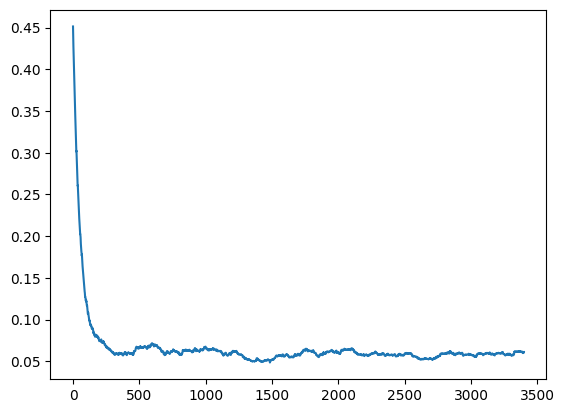

In [15]:
if is_jupyter:  
    plt.plot(plot_sliding_window(value_loss_1))

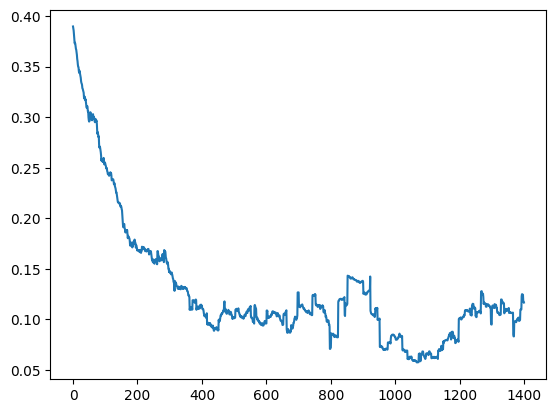

In [45]:
if is_jupyter:
    plt.plot(plot_sliding_window(policy_loss_1))

## Write Data

In [21]:
save_path = get_save_path(out_folder,save_name,seed,use_date=save_with_date)

In [22]:
delete_duplicate_results(out_folder,"",results)

In [23]:
json.dump(results,open('../results/'+save_path,'w'))